# PHYS20762 - Project 2 - Numerical Integration of Damped Harmonic Oscillator Differential Equations

University of Manchester  
Marawan Adam  
April 2023

In [45]:
from IPython.display import display, Markdown

display(Markdown(f'#### Report for Week 2023-04-17'))

#### Report for Week 2023-04-17

In [ ]:
# Initialisation

# Standard library
import string
from math import *
import random
from typing import Union, Callable, Tuple
from pathlib import Path

# Third Party 
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci

plt.rcParams.update({'font.size': 14})
plt.style.use('default')

## Theory

The equation for a mass-spring system under an external force is:

$$ m \frac{\textrm{d}^{2} x}{\textrm{d} t^{2}} + b \frac{\textrm{d} x}{\textrm{d} t} + k x = F(t)$$

where $m$ is the mass, $b$ is the damping constant, $k$ is the spring constant and $F(t)$ is the external force. During the comparison stage between the numerical methods, the external force will be $F(t) = 0$. Once the optimal method is determined, analyses will be carried out at $F(t_{i}) = F_{0}$ (where $t_{i}$ is a discrete chosen position in time) and $F(t) = F_{0} cos(\omega t)$.

The natural freqency and damping ratio of the system are:

$$ \omega_{0} = \sqrt{\frac{k}{m}} \quad \textrm{and} \quad \gamma = \frac{b}{m}$$
 
and the quality factor of the system is:

$$ Q = \frac{\omega_{0}}{\gamma} $$

Damping occurs when $b > 0$, and the following conditions lead to different states:

$$ Q > \frac{1}{2} \quad \textrm{or} \quad b < b_{critical}: \textrm{underdamped system}$$
$$ Q = \frac{1}{2} \quad \textrm{or} \quad b = b_{critical}: \textrm{critically-damped system}$$
$$ Q < \frac{1}{2} \quad \textrm{or} \quad b > b_{critical}: \textrm{overdamped system}$$

where $b_{critical} = 2 \sqrt{k m}$.

In [46]:
# Starting parameters

spring_k = 0.93 # kgms^-2
mass = 5.1 # kg

# Critical damping occurs at Q = 1/2
critical_b = 2 * np.sqrt(mass * spring_k)

print(f"{critical_b=}")

critical_b=4.355685939091569


## Comparison of Numerical Methods

### Equations

The equation of motion for a damped harmonic oscillator will be solved with the following four numerical methods:

1. **Euler Method**:
$$x_{i+1} = x_{i} + h v_{i}$$
$$v_{i+1} = v_{i} + h a_{i}$$
where $a_{i} = - \frac{k}{m} x_{i} - \frac{b}{m} v_{i}$.


2. **Improved Euler Method**
$$x_{i+1} = x_{i} + h v_{i} + \frac{h^{2}}{2} a_{i}$$
$$v_{i+1} = v_{i} + h a_{i}$$
where $a_{i} = - \frac{k}{m} x_{i} - \frac{b}{m} v_{i}$.


3. **Euler-Cromer Method**
$$v_{i+1} = v_{i} + h a_{i}$$
$$x_{i+1} = x_{i} + h v_{i+1}$$
where $a_{i} = - \frac{k}{m} x_{i} - \frac{b}{m} v_{i}$.


4. **Verlet Method**
$$x_{i+1} = A x_{i} + B x_{i-1}$$
$$v_{i} = \frac{x_{i+1} - x_{i-1}}{2 h}$$
where $A = 2 \frac{(2 m - k h^{2})}{D}$, $B = \frac{(b h - 2 m)}{D}$ and $D = 2 m + b h$.


The numerical methods will be compared with the analytical solutions, which for $b \neq b_{critical}$, start with:

$$ x(t) = e^{- \frac{\gamma t}{2}} (A e^{i \omega t} + B e^{- \omega t}) $$

The initial conditions are set to $x_{0} = 0$ and $v_{0} = -1$, which yield the following coefficients $A$ and $B$:

$$ A = - \frac{1}{2 i \omega} \quad and \quad B = \frac{1}{2 i \omega} $$

When substituted back into the original equation for $x(t)$, the solutions are:

$$ x(t) = - \frac{1}{2 i \omega} e^{- \frac{\gamma t}{2}} (e^{i \omega t} - e^{- \omega t}) $$

$$ v(t) = e^{- \frac{\gamma t}{2}} \left[\frac{\gamma}{4 i \omega} (e^{i \omega t} - e^{- i \omega t}) - \frac{1}{2} (e^{i \omega t} + e^{- i \omega t})\right] $$

In [59]:
# Numerical Methods

class NumericalMethods:
    def __init__(self, mass: float, spring_k: float, damping_const_b: float, h_step: float, time_period: float):
        self.m = mass
        self.k = spring_k
        self.b = damping_const_b
        self.h = h_step
        self.no_of_steps = int(time_period / self.h)
        self.t_domain = np.arange(0, time_period, self.h)
        
        
    def initialise_x_v(self, extra_verlet_element: int=0) -> None:
        """
        This function initialises the displacement 'x', velocity 'v' and energy 'E' arrays
        that will be populated when the numerical methods are called. The initialisation includes 
        the setting of the inital values for x, v and E.

        Parameters:
            extra_verlet_element: In order for the verlet method to run properly, the x, v and E
                                arrays need an extra, temporary element that gets removed once
                                the calculations end.
        """
        self.x = np.zeros(self.no_of_steps + extra_verlet_element)
        self.v = np.zeros(self.no_of_steps + extra_verlet_element)
        self.E = np.zeros(self.no_of_steps + extra_verlet_element)
        self.x[0] = 0
        self.v[0] = -1
        # E_0 arises from the equation for total energy outlined later in the report, and the above starting parameters
        self.E[0] = self.m / 2
        
        
    def euler_method(self) -> Tuple[np.ndarray]:
        """
        This function uses the Euler numerical method to calculate the solutions for
        x, v and E.

        Returns:
            A tuple of the x, v and E arrays.
        """
        self.initialise_x_v()

        for i in range(self.no_of_steps - 1):

            a = (-self.k/self.m) * self.x[i] - (self.b/self.m) * self.v[i]

            self.x[i + 1] = self.x[i] + (self.h * self.v[i])
            self.v[i + 1] = self.v[i] + (self.h * a)
            
        self.E = 0.5 * self.k * self.x**2 + 0.5 * self.m * self.v**2

        return self.x, self.v, self.E

    
    def improv_euler_method(self) -> Tuple[np.ndarray]:
        """
        This function uses the Improved Euler numerical method to calculate the
        solutions for x, v and E.

        Returns:
            A tuple of the x, v and E arrays.
        """
        self.initialise_x_v()
        
        for i in range(self.no_of_steps - 1):

            a = (-self.k/self.m) * self.x[i] - (self.b/self.m) * self.v[i]

            self.x[i + 1] = self.x[i] + (self.h * self.v[i]) + (self.h**2 / 2) * a
            self.v[i + 1] = self.v[i] + (self.h * a)
            
        self.E = 0.5 * self.k * self.x**2 + 0.5 * self.m * self.v**2

        return self.x, self.v, self.E

    
    def euler_cromer_method(self) -> Tuple[np.ndarray]:
        """
        This function uses the Euler-Cromer numerical method to calculate the
        solutions for x, v and E.

        Returns:
            A tuple of the x, v and E arrays.
        """
        self.initialise_x_v()
        
        for i in range(self.no_of_steps - 1):
            
            a = (-self.k/self.m) * self.x[i] - (self.b/self.m) * self.v[i]

            self.v[i + 1] = self.v[i] + (self.h * a)
            # The big difference between Euler and Euler-Cromer is this step here for 'x',
            # v[i + 1] is used instead of v[i].
            self.x[i + 1] = self.x[i] + self.h * self.v[i + 1]
            
        self.E = 0.5 * self.k * self.x**2 + 0.5 * self.m * self.v**2

        return self.x, self.v, self.E
    
    
    def verlet_method(self) -> Tuple[np.ndarray]:
        """
        This function uses the Verlet numerical method to calculate the
        solutions for x, v and E.

        Returns:
            A tuple of the x, v and E arrays.
        """
        self.initialise_x_v(extra_verlet_element=1)

        # The Euler method is used to calculate the first few elements, before
        # the Verlet method takes over.
        a = (-self.k/self.m) * self.x[0] - (self.b/self.m) * self.v[0]
        
        self.x[1] = self.x[0] + (self.h * self.v[0])
        self.v[1] = self.v[0] + (self.h * a)

        for i in range(1, self.no_of_steps):
            D = 2*self.m + self.b*self.h
            A = 2 * ((2*self.m - self.k*self.h**2) / D)
            B = (self.b*self.h - 2*self.m) / D
            
            self.x[i + 1] = A * self.x[i] + B * self.x[i - 1]
            self.v[i] = (self.x[i + 1] - self.x[i - 1]) / (2 * self.h)
            
        # The solutions have their last elements removed, which were only necessary
        # for the calculations as they are out of bounds of the time period.
        self.x = self.x[:-1].copy()
        self.v = self.v[:-1].copy()
        
        self.E = 0.5 * self.k * self.x**2 + 0.5 * self.m * self.v**2

        return self.x, self.v, self.E

    
    def analytical_solution(self) -> Tuple[np.ndarray]:
        """
        This function uses the analytical approach to calculate the
        solutions for x, v and E.

        Returns:
            A tuple of the x, v and E arrays.
        """
        t = self.t_domain
        gamma = self.b / self.m
        natural_freq = np.sqrt(self.k / self.m)
        omega = np.sqrt(np.abs(natural_freq**2 - (gamma**2 / 4)))
        exp_pairs = [np.exp(1j * omega * t) - np.exp(- 1j * omega * t),
                     np.exp(1j * omega * t) + np.exp(- 1j * omega * t)]
        e_term = np.exp((- gamma * t) / 2)

        self.x = (- 1 / (2*1j*omega)) * e_term * exp_pairs[0]
        self.v = e_term * ((gamma / (4 * 1j * omega)) * exp_pairs[0] + (-1/2) * exp_pairs[1])
        
        self.E = 0.5 * self.k * self.x.real**2 + 0.5 * self.m * self.v.real**2

        return self.x.real, self.v.real, self.E
    

### Plot comparisons

The first set of plots will be of the numerical methods with a fixed time step of $h = 0.01$ s. The indepenent variable will be the damping constant $b$.

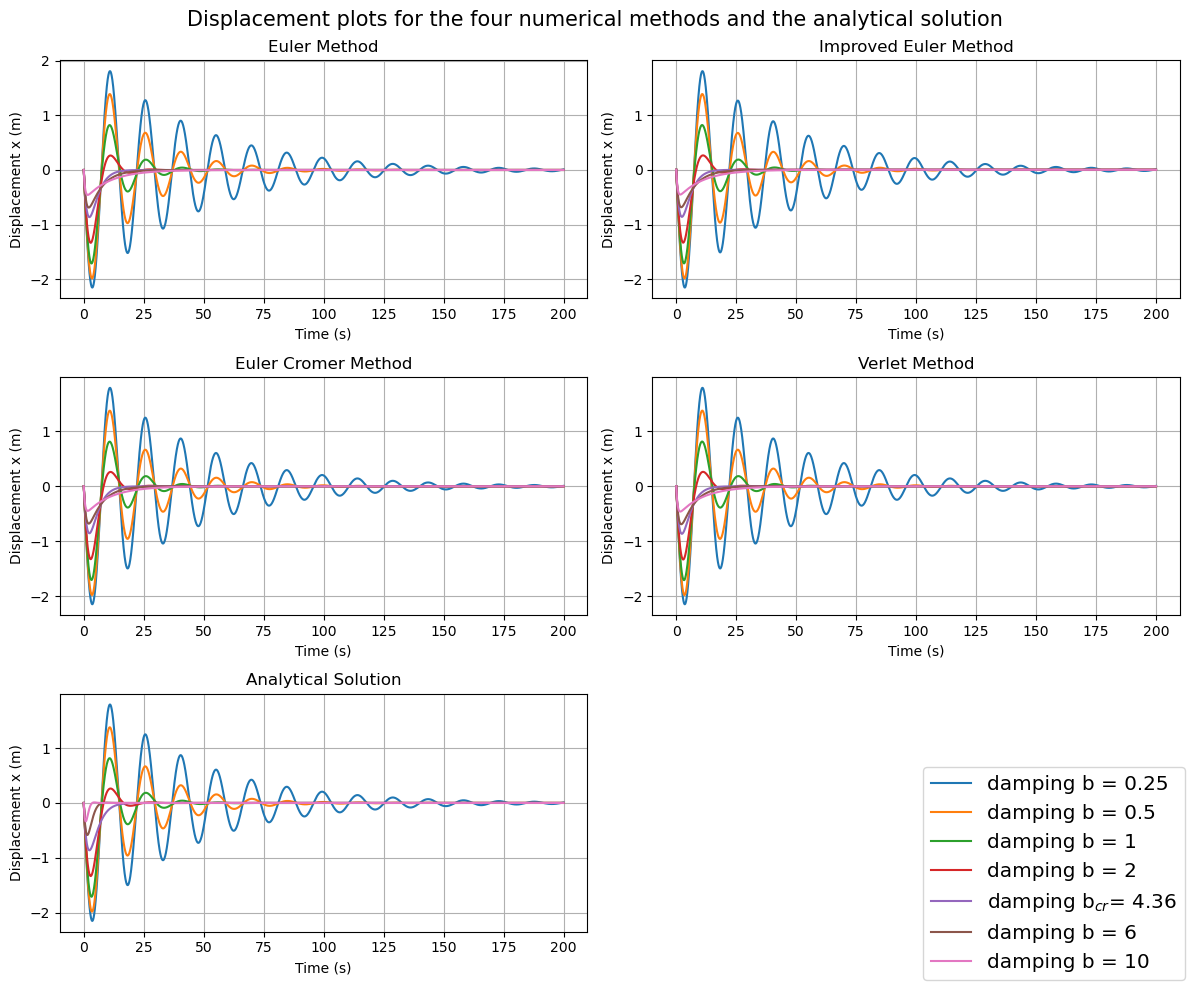

In [64]:
def plot_method_var(fig, nm_object, method_index: int, axes, label: str):
    ax1, ax2, ax3, ax4, ax5 = [ax for _, ax in axes]
    ax1.plot(nm_object.t_domain, nm_object.euler_method()[method_index], label=label)
    ax2.plot(nm_object.t_domain, nm_object.improv_euler_method()[method_index], label=label)
    ax3.plot(nm_object.t_domain, nm_object.euler_cromer_method()[method_index], label=label)
    ax4.plot(nm_object.t_domain, nm_object.verlet_method()[method_index], label=label)
    ax5.plot(nm_object.t_domain, nm_object.analytical_solution()[method_index], label=label)
    

def setup_method_axes(fig):
    axes = [("Euler Method", fig.add_subplot(321)),
       ("Improved Euler Method", fig.add_subplot(322)),
       ("Euler Cromer Method", fig.add_subplot(323)),
       ("Verlet Method", fig.add_subplot(324)),
       ("Analytical Solution", fig.add_subplot(325))]
    return axes
    

fig = plt.figure(figsize=(12, 10))
fig.suptitle("Displacement plots for the four numerical methods and the analytical solution", fontsize=15)
axes = setup_method_axes(fig)

for damping_b in [0.25, 0.5, 1, 2, critical_b, 6, 10]:
    nm = NumericalMethods(mass, spring_k, damping_const_b=damping_b, h_step=0.01, time_period=200)
    label = r"damping b$_{cr}$" + f"= {round(damping_b, 2)}" \
            if damping_b == critical_b else f"damping b = {damping_b}"
    plot_method_var(fig, nm, 0, axes, label)
    
for i, (ax_name, ax) in enumerate(axes):
    ax.grid()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Displacement x (m)")
    ax.set_title(ax_name)
    
handles, labels = axes[0][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', fontsize='x-large')
    
plt.tight_layout()
plt.show()

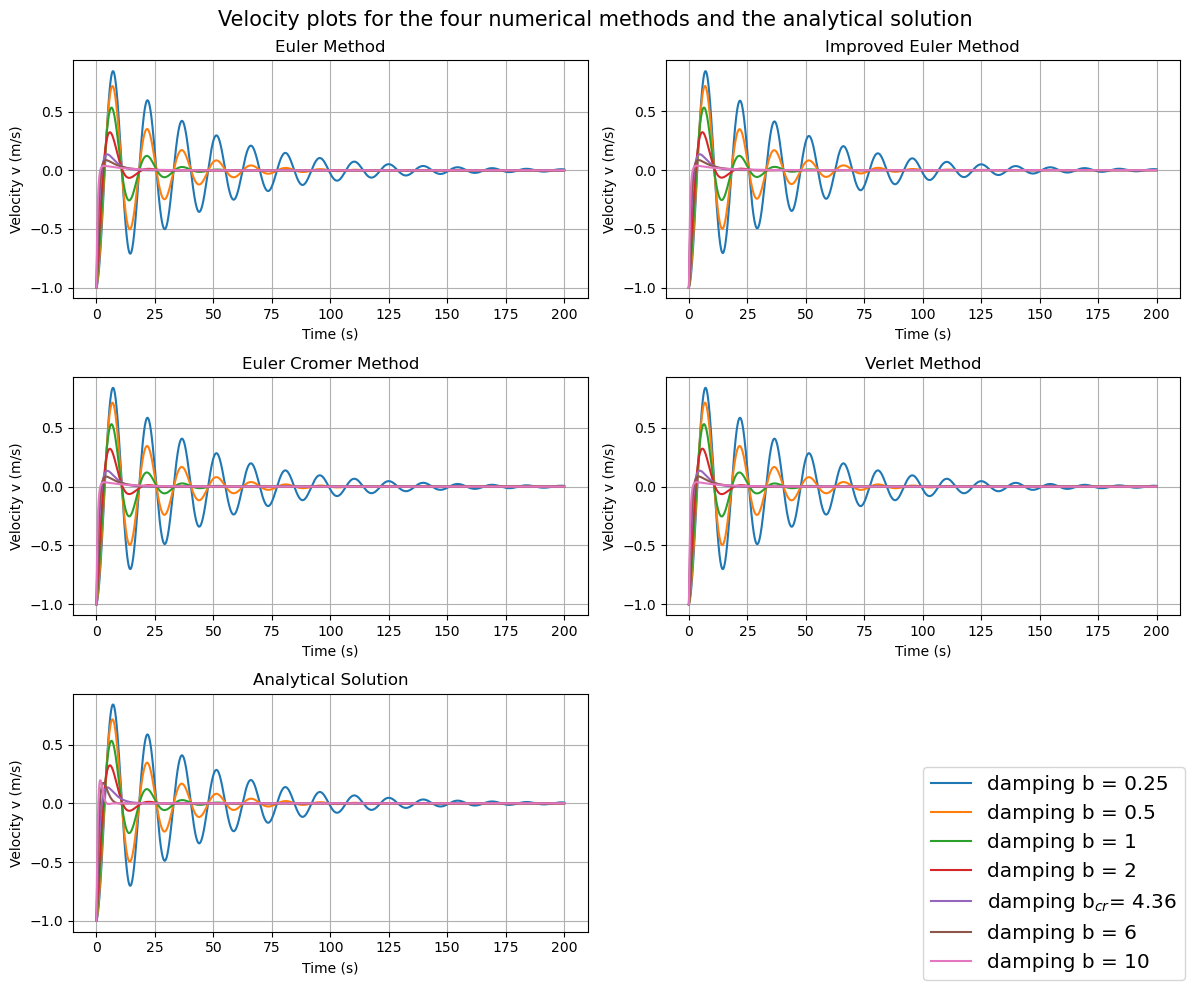

In [65]:
fig = plt.figure(figsize=(12, 10))
fig.suptitle("Velocity plots for the four numerical methods and the analytical solution", fontsize=15)
axes = setup_method_axes(fig)

for damping_b in [0.25, 0.5, 1, 2, critical_b, 6, 10]:
    nm = NumericalMethods(mass, spring_k, damping_const_b=damping_b, h_step=0.01, time_period=200)
    label = r"damping b$_{cr}$" + f"= {round(damping_b, 2)}" \
            if damping_b == critical_b else f"damping b = {damping_b}"
    plot_method_var(fig, nm, 1, axes, label)
    
for i, (ax_name, ax) in enumerate(axes):
    ax.grid()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Velocity v (m/s)")
    ax.set_title(ax_name)
    
handles, labels = axes[0][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', fontsize='x-large')
    
plt.tight_layout()
plt.show()

It is immediately clear that varying the damping constant $b$ greatly affects the subsequent motion. Every time the damping constant is increased to the next discrete value, both the displacement and velocity converge to $0$ sooner. All the plots under $b = b_{cr}$ are visibly underdamped, while all the plots above are overdamped, albeit not as clearly.

At this time step of $h = 0.01$ s, there is no visible difference between the numerical methods at every damping constant. The only graphical difference between the numerical methods and the analytical solution is at $b = 10$, where the system's displacement returns to equilibrium slower on the numerical plots.

Since the overdamped plots were largely hidden by the underdamped curves, they have been reproduced with the critically-damped solution, for closer inspection.

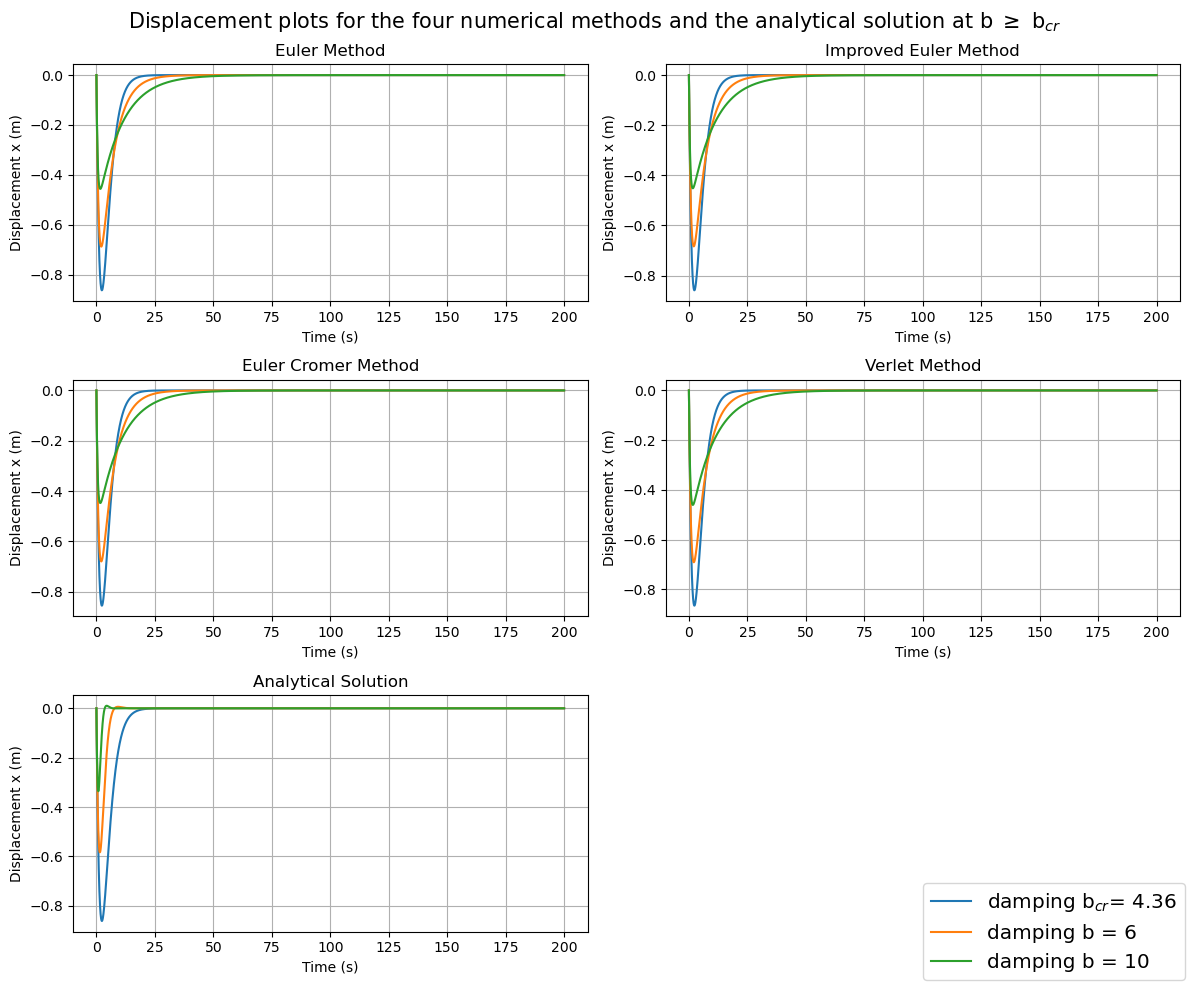

In [66]:
fig = plt.figure(figsize=(12, 10))
fig.suptitle(r"Displacement plots for the four numerical methods and the analytical solution at b $\geq$ b$_{cr}$", fontsize=15)
axes = setup_method_axes(fig)

for damping_b in [critical_b, 6, 10]:
    nm = NumericalMethods(mass, spring_k, damping_const_b=damping_b, h_step=0.01, time_period=200)
    label = r"damping b$_{cr}$" + f"= {round(damping_b, 2)}" \
            if damping_b == critical_b else f"damping b = {damping_b}"
    plot_method_var(fig, nm, 0, axes, label)
    
for i, (ax_name, ax) in enumerate(axes):
    ax.grid()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Displacement x (m)")
    ax.set_title(ax_name)
    
handles, labels = axes[0][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', fontsize='x-large')
    
plt.tight_layout()
plt.show()

The increased resolution of the graphs has not produced a discernible difference between the numerical methods. Therefore, the methods will now be plotted at an increased time step of $h = 1$ s.

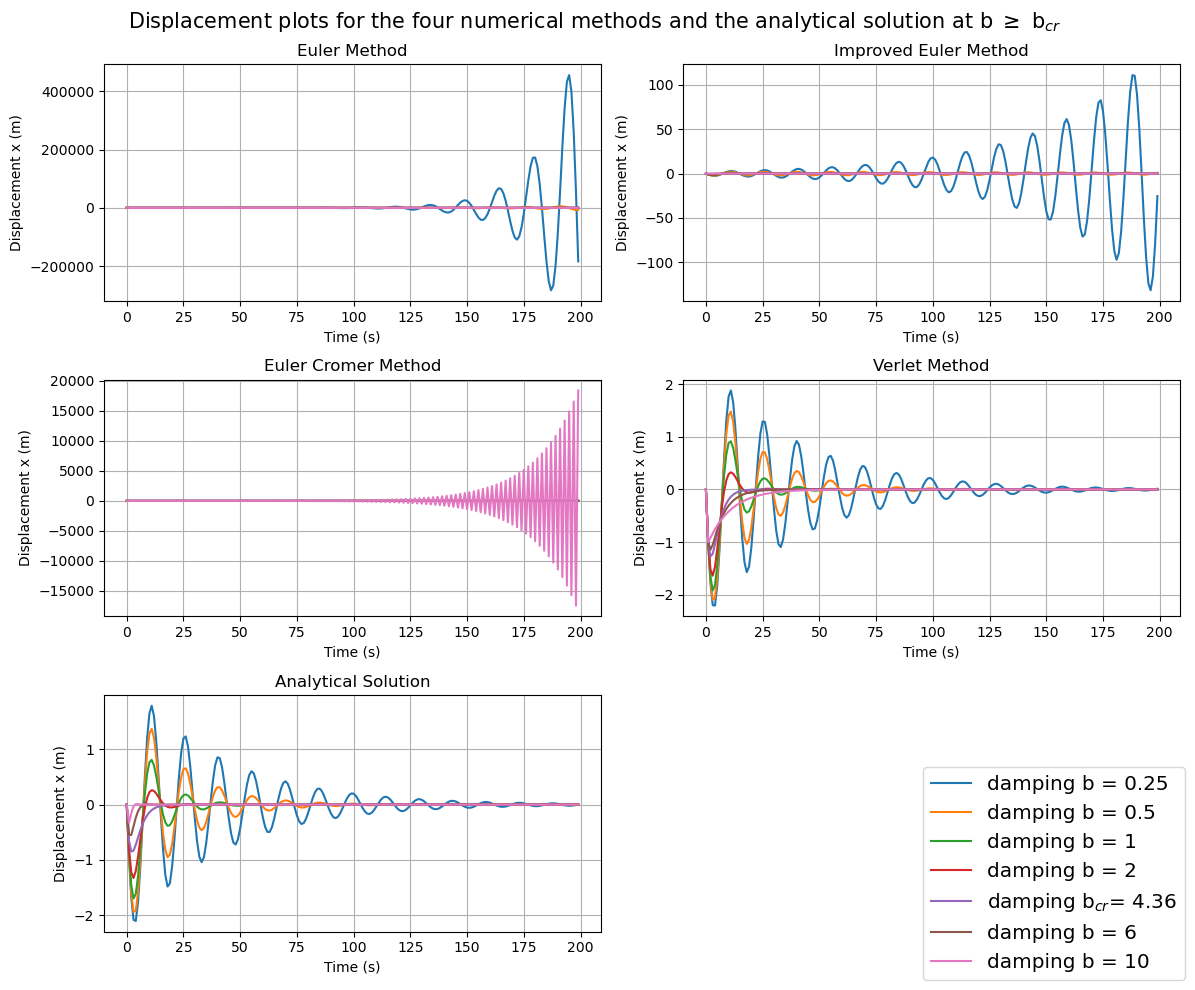

In [70]:
fig = plt.figure(figsize=(12, 10))
fig.suptitle(r"Displacement plots for the four numerical methods and the analytical solution at b $\geq$ b$_{cr}$", fontsize=15)
axes = setup_method_axes(fig)

for damping_b in [0.25, 0.5, 1, 2, critical_b, 6, 10]:
    nm = NumericalMethods(mass, spring_k, damping_const_b=damping_b, h_step=1, time_period=200)
    label = r"damping b$_{cr}$" + f"= {round(damping_b, 2)}" \
            if damping_b == critical_b else f"damping b = {damping_b}"
    plot_method_var(fig, nm, 0, axes, label)
    
for i, (ax_name, ax) in enumerate(axes):
    ax.grid()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Displacement x (m)")
    ax.set_title(ax_name)
    
handles, labels = axes[0][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', fontsize='x-large')
    
plt.tight_layout()
plt.show()

The hierarchy has taken shape. Once the time step was increased, the method that deteriorated fastest was the Euler-Cromer method, which produced an incomprehensible plot. Following on, the next best method was the Euler method, which produced a visible, diverging curve for $b = 0.25$. The Improved Euler method produced a similar plot, however it diverged much slower than the Euler method, which made it more accurate. The **best numerical method**, which matched the analytical solution quite closely despite the considerable time step increase, was the **Verlet method**. 

Despite the fact that it is already clear that the Verlet method is the best method for calculating the solutions to the equation of motion, a quantitive analysis is still necessary. To do so, the methods have been used to calculate the system's energy at every point within the time period, when $b = 0$. With the damping constant set to zero, the system's energy should be conserved.

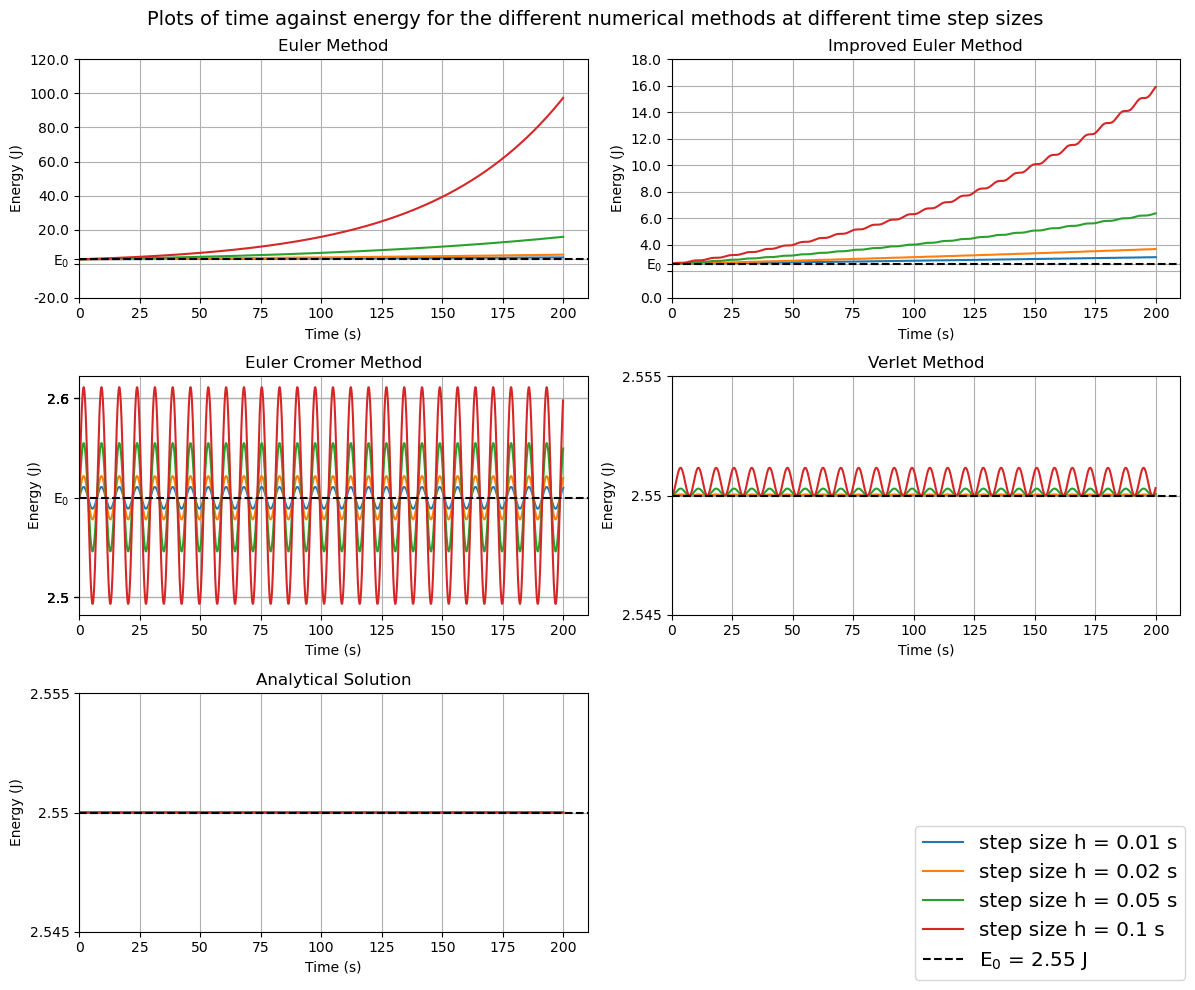

In [42]:
def add_specific_ticks(ax, values: list, unit: str, labels: list=None, clear_space=False, axis_choice='y') -> None:
    """
    This function adds lines, their ticks and optional labels to the specified axis.

    Parameters:
        ax: figure axis object inputted by user
        values: The points on the axis where the lines should be plotted
        unit: The unit that the values are in
        labels: List of labels for all the values
        clear_space: Allows the user to decide whether or not neighbouring tick labels
                    are removed for clarity.
        axis_choice: 'x' or 'y' axis. 'y' DEFAULT.
    """
    if axis_choice == 'x':
        for val, label in zip(values, labels):
            ax.axvline(val, linestyle='--', color='k', label=label + f" = {val} {unit}" if label else f"{val} {unit}")
        ticks = sorted(list(np.round(ax.get_xticks(), 1)) + values)
    if axis_choice == 'y':
        for val, label in zip(values, labels):
            ax.axhline(val, linestyle='--', color='k', label=label + f" = {val} {unit}" if label else f"{val} {unit}")
        ticks = sorted(list(np.round(ax.get_yticks(), 1)) + values)
    tick_labels = list(ticks)
    if labels:
        # This part of the functions clears room around the values' tick labels
        if clear_space:
            for val in values:
                value_index = ticks.index(val)
                if value_index == 0:
                    tick_labels[1] = ''
                elif np.abs(ticks[value_index - 1] - val) < np.abs(ticks[value_index + 1] - val):
                    tick_labels[value_index - 1] = ''
                else:
                    tick_labels[value_index + 1] = ''
        for val, label in zip(values, labels):
            tick_labels[ticks.index(val)] = label
    if axis_choice == 'x':
        ax.set_xticks(ticks)
        ax.set_xticklabels(tick_labels)
    elif axis_choice == 'y':
        ax.set_yticks(ticks)
        ax.set_yticklabels(tick_labels)


fig = plt.figure(figsize=(12, 10))
fig.suptitle("Plots of time against energy for the different numerical methods at different time step sizes", fontsize=14)
axes = setup_method_axes(fig)

for h_step in [0.01, 0.02, 0.05, 0.1]:
    nm = NumericalMethods(mass, spring_k, damping_const_b=0, h_step=h_step, time_period=200)
    label = f"step size h = {h_step} s"
    plot_method_var(fig, nm, 2, axes, label)
    
for i, (ax_name, ax) in enumerate(axes):
    add_specific_ticks(ax, [E_0], unit="J", labels=[r"E$_{0}$"], clear_space=True if i < 2 else False)
    ax.grid()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Energy (J)")
    ax.set_title(ax_name)
    ax.set_xlim(xmin=0)
    if i > 2:
        ax.set_ylim((2.545, 2.555))
        y_range = np.linspace(2.545, 2.555, 3)
        ax.set_yticks(y_range)
        ax.set_yticklabels(y_range)
    
handles, labels = axes[0][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', fontsize='x-large')
    
plt.tight_layout()
plt.show()


As expected, the Euler and Improved Euler methods perform poorly as soon as the step size increases above $h = 0.01$ s. The system energy increases exponentially by $h = 0.1$, which explains why the solution curves diverged in the earlier plots when the time step was increased. Although the Euler-Cromer method appeared to be the worst method in the previous analysis, it fares better than Euler and Improved Euler in the energy comparison. The energy of the system oscillates over time, however its amplitude remains constant, which means it is conserved. The most accurate method remains the Verlet method. It conserves the energy, and the oscillations are confined to a smaller range compared to the Euler-Cromer method.

## Analysis of best method

Now that the **Verlet method** has been chosen as the optimal numerical method, it will be used to solve the equation of motion for a mass-spring system under an external force, the first being an instantaneous 'push'. A new class has been created for the modified Verlet method.

In [43]:
class ImprovedMethods(NumericalMethods):
    def __init__(self, mass: float, spring_k: float, damping_const_b: float, h_step: float, time_period: float):
        super().__init__(mass, spring_k, damping_const_b, h_step, time_period)
        
    def verlet_method(self,
                      force: float=None,
                      force_indices: list=None,
                      driving_force_bool: bool=False, 
                      driving_force: np.ndarray=None) -> Tuple[np.ndarray]:
        """
        This function uses the Verlet numerical method to calculate the
        solutions for x, v and E. It has added functionality for two use cases
        where F != 0: an instantaneous 'push', and a sinusoidal driving force.
        
        Parameters:
            force: Magnitude of the 'push' applied to the system at the inputted indices.
            force_indices: List of indices the user wants the force to be applied at.
            driving_force_bool: Boolean that determines whether or not a driving signal is inputted.
            driving_force: An array containing the sinusoidal driving force over the time period.

        Returns:
            A tuple of the x, v and E arrays.
        """
        self.initialise_x_v(extra_verlet_element=1)

        if driving_force_bool:
            a = (-self.k/self.m) * self.x[0] - (self.b/self.m) * self.v[0] + driving_force[0] / self.m
        elif force and 0 in force_indices:
            a = (-self.k/self.m) * self.x[0] - (self.b/self.m) * self.v[0] + force / self.m
        else:
            a = (-self.k/self.m) * self.x[0] - (self.b/self.m) * self.v[0]
        
        self.x[1] = self.x[0] + (self.h * self.v[0])
        self.v[1] = self.v[0] + (self.h * a)

        for i in range(1, self.no_of_steps):

            D = 2*self.m + self.b*self.h
            A = 2 * ((2*self.m - self.k*self.h**2) / D)
            B = (self.b*self.h - 2*self.m) / D
            if driving_force_bool:
                self.x[i + 1] = A * self.x[i] + B * self.x[i - 1] + (2*driving_force[i]*self.h**2) / D
            elif force and i in force_indices:
                self.x[i + 1] = A * self.x[i] + B * self.x[i - 1] + (2*force*self.h**2) / D
            else:
                self.x[i + 1] = A * self.x[i] + B * self.x[i - 1]
            self.v[i] = (self.x[i + 1] - self.x[i - 1]) / (2 * self.h)
            
        self.x = self.x[:-1].copy()
        self.v = self.v[:-1].copy()
        
        self.E = 0.5 * self.k * self.x**2 + 0.5 * self.m * self.v**2

        return self.x, self.v, self.E    
    

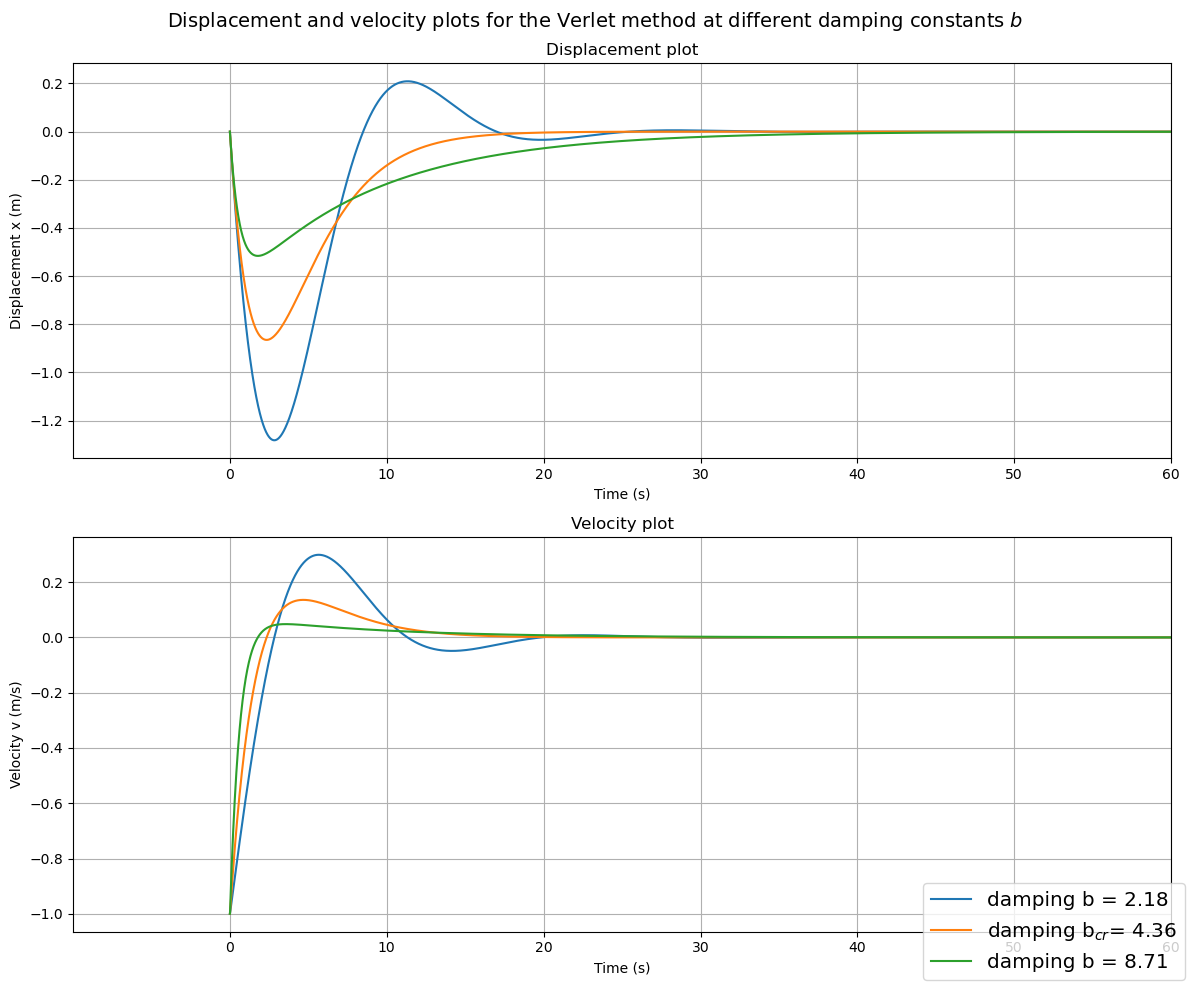

In [71]:
fig = plt.figure(figsize=(12, 10))
fig.suptitle(r"Displacement and velocity plots for the Verlet method at different damping constants $b$", fontsize=14)
axes = [("Displacement plot", fig.add_subplot(211)),
       ("Velocity plot", fig.add_subplot(212))]
    
for i, (ax_name, ax) in enumerate(axes):
    # Verlet method plotted for 1/2 the critical_b, critical_b, and 2 x critical_b
    for damping_b in [0.5 * critical_b, critical_b, 2 * critical_b]:
        im = ImprovedMethods(mass, spring_k, damping_const_b=damping_b, h_step=0.01, time_period=200)
        label = r"damping b$_{cr}$" + f"= {round(damping_b, 2)}" \
            if damping_b == critical_b else f"damping b = {round(damping_b, 2)}"
        if i % 2 == 0:
            ax.plot(im.t_domain, im.verlet_method()[0], label=label)
            ax.set_ylabel("Displacement x (m)")
        else:
            ax.plot(im.t_domain, im.verlet_method()[1], label=label)
            ax.set_ylabel("Velocity v (m/s)")

    ax.grid()
    ax.set_xlabel("Time (s)")
    ax.set_title(ax_name)
    ax.set_xlim(xmax=60)
    
handles, labels = axes[0][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', fontsize='x-large')
    
plt.tight_layout()
plt.show()

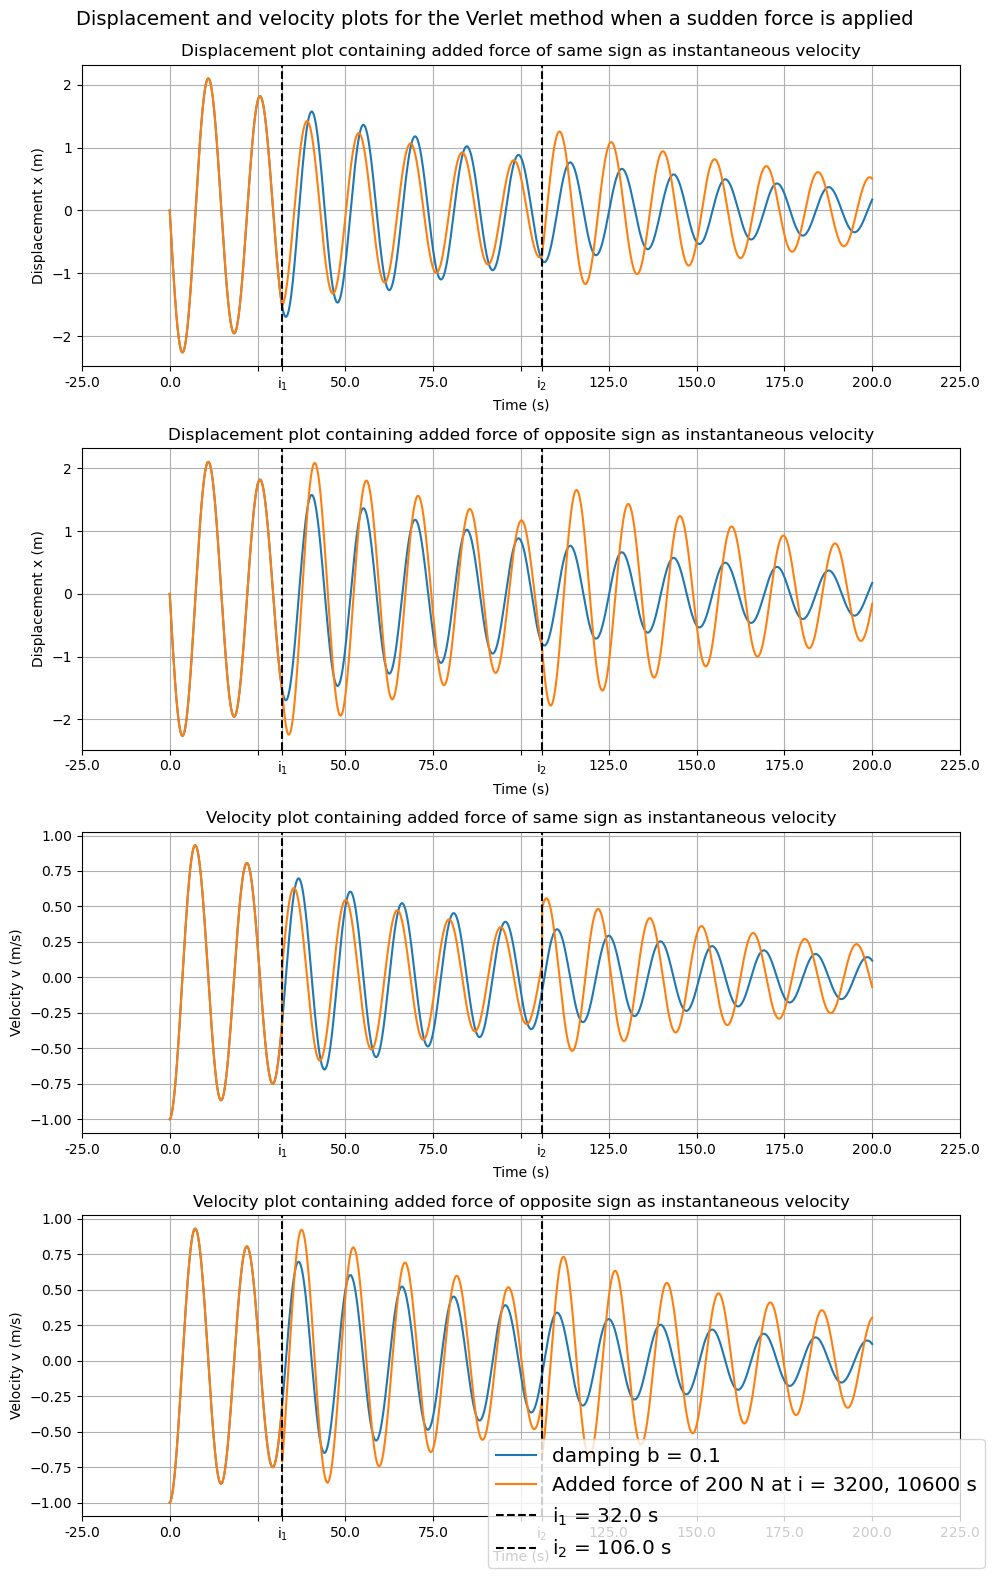

In [73]:
fig_v = plt.figure(figsize=(10, 16))
fig_v.suptitle(r"Displacement and velocity plots for the Verlet method when a sudden force is applied", fontsize=14)
axes_v = [("\nDisplacement plot containing added force of same sign as instantaneous velocity", fig_v.add_subplot(411)),
        ("Displacement plot containing added force of opposite sign as instantaneous velocity", fig_v.add_subplot(412)),
       ("Velocity plot containing added force of same sign as instantaneous velocity", fig_v.add_subplot(413)),
       ("Velocity plot containing added force of opposite sign as instantaneous velocity", fig_v.add_subplot(414))]
    
force = 200 # N
oscillations = [3200, 10600] # index positions in solutions
osc_times = [x / 100 for x in oscillations] # time positions
force_label = f"Added force of {force} N at i = {', '.join((str(x) for x in oscillations))} s"

for i, (ax_name, ax) in enumerate(axes_v):
    for damping_b in [0.1]:
        im = ImprovedMethods(mass, spring_k, damping_const_b=damping_b, h_step=0.01, time_period=200)
        label = f"damping b = {damping_b}"
        ax.plot(im.t_domain, im.verlet_method()[0 if i < 2 else 1], label=label)
        if "same" in ax_name:
            ax.plot(im.t_domain, im.verlet_method(force, oscillations)[0 if i < 2 else 1], label=force_label)
        else:
            ax.plot(im.t_domain, im.verlet_method(- force, oscillations)[0 if i < 2 else 1], label=force_label)
        ax.set_ylabel("Displacement x (m)") if i < 2 else ax.set_ylabel("Velocity v (m/s)")

    add_specific_ticks(ax, osc_times, unit="s", labels=[r"i$_{1}$", r"i$_{2}$"], clear_space=True, axis_choice='x')
    ax.grid()
    ax.set_xlabel("Time (s)")
    ax.set_title(ax_name)
    
handles, labels = axes_v[0][1].get_legend_handles_labels()
fig_v.legend(handles, labels, loc='lower right', fontsize='x-large')
    
plt.tight_layout()
plt.show()

$\omega_{0} =$ 0.427

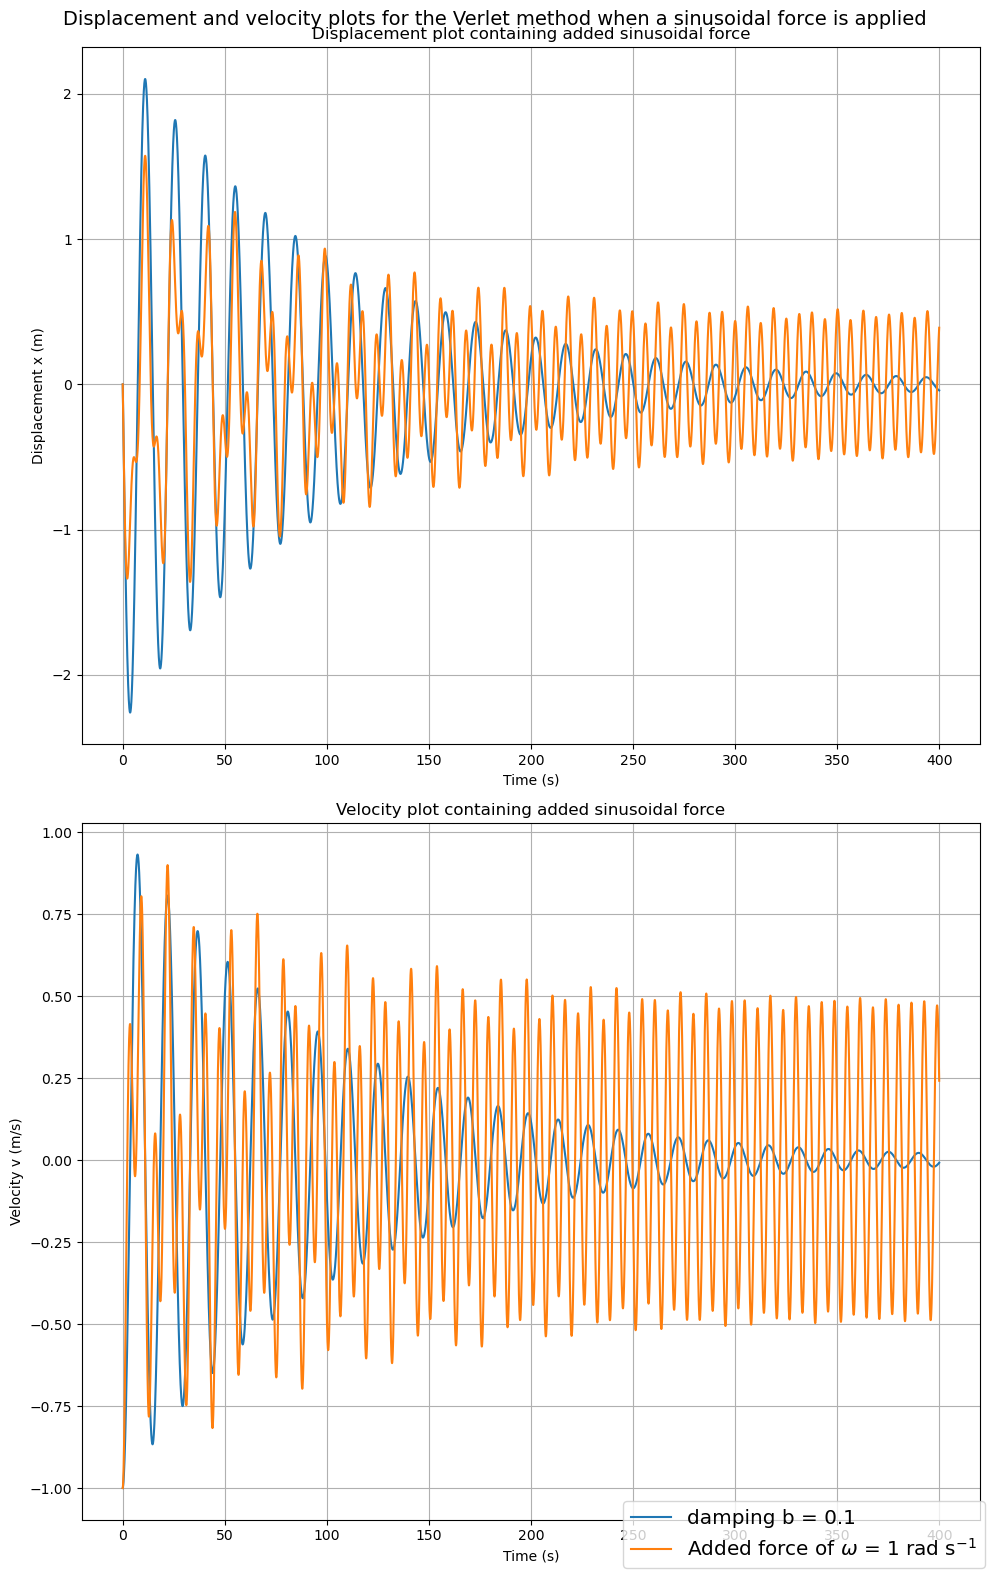

In [35]:
fig_v = plt.figure(figsize=(10, 16))
fig_v.suptitle(r"Displacement and velocity plots for the Verlet method when a sinusoidal force is applied", fontsize=14)
axes_v = [("Displacement plot containing added sinusoidal force", fig_v.add_subplot(211)),
        ("Velocity plot containing added sinusoidal force", fig_v.add_subplot(212))]

natural_freq = np.sqrt(spring_k / mass)
display(Markdown(r"$\omega_{0} =$" + f" {round(natural_freq, 3)}"))

force_0 = 2 # N
period = 400 # s
ang_frequency = 1 # rad s^-1
time = np.arange(0, period, 0.01)
force_signal = force_0 * np.sin(ang_frequency * time) # N
force_label = f"Added force of " + r"$\omega$" + f" = {ang_frequency} " + r"rad s$^{-1}$"

for i, (ax_name, ax) in enumerate(axes_v):
    for damping_b in [0.1]:
        im = ImprovedMethods(mass, spring_k, damping_const_b=damping_b, h_step=0.01, time_period=period)
        label = f"damping b = {damping_b}"
        if i == 0:
            ax.plot(im.t_domain, im.verlet_method()[0], label=label)
            ax.plot(im.t_domain, im.verlet_method(driving_force_bool=True, driving_force=force_signal)[0], label=force_label)
        if i == 1:
            ax.plot(im.t_domain, im.verlet_method()[1], label=label)
            ax.plot(im.t_domain, im.verlet_method(driving_force_bool=True, driving_force=force_signal)[1], label=force_label)
        ax.set_ylabel("Displacement x (m)") if i == 0 else ax.set_ylabel("Velocity v (m/s)")

    ax.grid()
    ax.set_xlabel("Time (s)")
    ax.set_title(ax_name)
    
#     ax.set_xlim(xmin=250)
    
handles, labels = axes_v[0][1].get_legend_handles_labels()
fig_v.legend(handles, labels, loc='lower right', fontsize='x-large')
    
plt.tight_layout()
plt.show()

## Conclusion

In summary, all the numerical methods performed well when the time step was sufficiently low, however, as soon it started to increase, the Euler, Improved Euler, and Euler-Cromer methods began to diverge from the analytical solution quite quickly. The Euler-Cromer method showed its merit as a *Symplectic Integrator* during the energy analysis. However, by far the best method was the Verlet method. It performed very well in both the solution plots and the energy analysis. It demonstrated that was it was capable of producing a sinusoidal solution after a transient period, which the others wouldn't have been able to do.